In [1]:
# basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# audio
import librosa, librosa.display
from IPython.display import Audio
from scipy.io import wavfile
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
# from tensorflow.sparse import to_dense
# import tensorflow_hub as hub
from scipy import signal


In [2]:
org_data = pd.read_pickle('new_bird_voice.pkl')
org_data.head()

common_name                 scientific_name recording_length     xc_id  \
0  Andean Guan  Penelope montagnii atrogularis             0:10  XC275186   
1  Andean Guan              Penelope montagnii             0:32  XC247280   
2  Andean Guan       Penelope montagnii brooki             1:08  XC238793   
3  Andean Guan       Penelope montagnii brooki             0:50  XC238791   
4  Andean Guan  Penelope montagnii atrogularis             0:43  XC238788   

   recording_length_seconds  \
0                        10   
1                        32   
2                        68   
3                        50   
4                        43   

                                            filename        label  \
0  C:\Users\aqua6\Desktop\DSML\Neural network\Pro...  Andean Guan   
1  C:\Users\aqua6\Desktop\DSML\Neural network\Pro...  Andean Guan   
2  C:\Users\aqua6\Desktop\DSML\Neural network\Pro...  Andean Guan   
3  C:\Users\aqua6\Desktop\DSML\Neural network\Pro...  Andean Guan   
4  C:\Users\aqua6\Desktop\DSML\Neural network\Pro...  Andean Guan   

                file  b_class  \
0  Andean Guan10.mp3        0   
1  Andean Guan11.mp3        0   
2  Andean Guan12.mp3        0   
3  Andean Guan13.mp3        0   
4  Andean Guan14.mp3        0   

                                         audio_array  
0  [[[[0.1282842], [0.387606], [0.53643084], [0.6...  
1  [[[[0.], [0.], [0.], [0.20137303], [0.44104123...  
2  [[[[0.19615711], [0.], [0.01969122], [0.], [0....  
3  [[[[0.22245625], [0.], [0.], [0.], [0.], [0.],...  
4  [[[[0.24720973], [0.28295952], [0.4126276], [0...

In [3]:
# Function to preprocess the spectrograms
def preprocess_audio(audio, sr, target_shape=(128, 128)):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Add a channel dimension (for grayscale: 1 channel)
    log_spectrogram = np.expand_dims(log_spectrogram, axis=-1)  # Shape (height, width, 1)

    # Resize the spectrogram to the target shape (e.g., 128x128)
    log_spectrogram_resized = tf.image.resize(log_spectrogram, target_shape)

    # Normalize to [0, 1]
    log_spectrogram_resized = (log_spectrogram_resized - np.min(log_spectrogram_resized)) / (np.max(log_spectrogram_resized) - np.min(log_spectrogram_resized))

    return log_spectrogram_resized

In [4]:
def reduce_background_noise(data, sr):
    # print("audio length:", len(data))
    stft_data = librosa.stft(data)
    # print("STFT shape:", stft_data.shape)
    magnitude, phase = librosa.magphase(stft_data)
    threshold = np.mean(magnitude) * 0.5
    magnitude[magnitude < threshold] = 0
    # print("Magnitude mean after thresholding:", np.mean(magnitude))
    reduced_noise_stft = magnitude * phase
    reduced_audio = librosa.istft(reduced_noise_stft)

    reduced_audio = librosa.util.fix_length(reduced_audio, size=len(data))
    # print("Reduced audio length:", len(reduced_audio))
    return reduced_audio

In [5]:
def background_sound_seperation(audio):
    S_full, phase = librosa.magphase(librosa.stft(audio))
    S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

    S_filter = np.minimum(S_full, S_filter)

    margin_v = 10
    power = 2

    mask_v = librosa.util.softmask(S_full - S_filter,
                                   margin_v * S_filter,
                                   power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components

    S_foreground = mask_v * S_full

    return S_full,S_foreground


In [6]:
# Model 1
def build_cnn_model(input_shape=(128, 128, 1)):
    model = Sequential()
    
    # 1st Convolutional Block
    model.add(Conv2D(46, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    # 2nd Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # 3rd Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(46, activation='softmax'))  # Change the number of classes as needed
    
    # Compile the model
    # Since below using one hot encoding, so change loss function from sparse to CategoricalCrossentropy
    model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['recall']) 

    
    return model


In [7]:
# Model 2
def cnn_2D_model_2(input_shape=(128, 128, 1)):
    model = Sequential([
        layers.Conv2D(46, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(46, activation='softmax')  # Adjust for number of classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['recall'])
    return model

# Sample of Noise Reduction Experiment

In [8]:
file = org_data.iloc[3].filename
audio_len = org_data.iloc[3].recording_length_seconds
audio, sr = librosa.load(file,sr=22050)


In [9]:
reduced_audio = reduce_background_noise(audio, sr)

In [10]:
S_full,S_foreground = background_sound_seperation(audio)

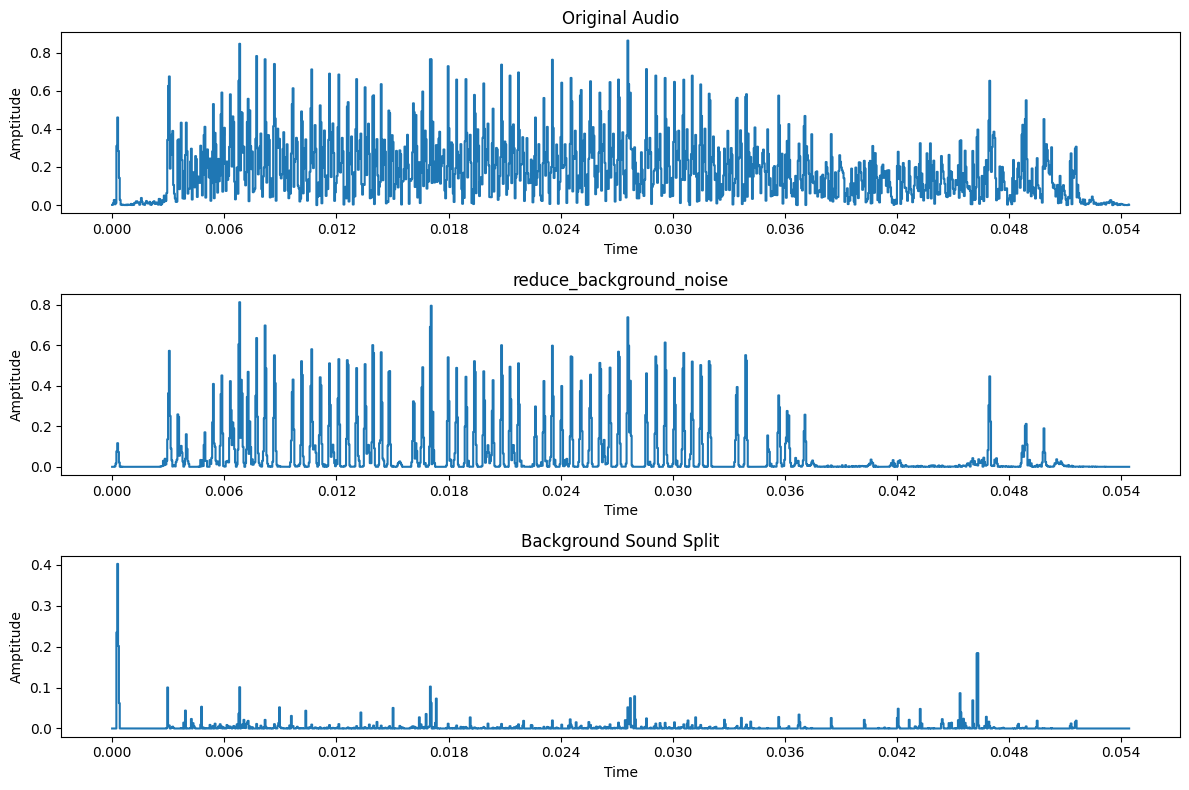

In [11]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.xlabel('Time')
plt.ylabel('Amptitude')
librosa.display.waveshow(S_full,sr=sr)
plt.title('Original Audio')

plt.subplot(3, 1, 2)
plt.xlabel('Time')
plt.ylabel('Amptitude')
n_fft = 2048 
hop_length = 512 
spectrogram = librosa.stft(reduced_audio, n_fft=n_fft, hop_length=hop_length)
magnitude_spectrogram = np.abs(spectrogram)
librosa.display.waveshow(magnitude_spectrogram,sr=sr)
plt.title('reduce_background_noise')

plt.subplot(3, 1, 3)

plt.xlabel('Time')
plt.ylabel('Amptitude')
librosa.display.waveshow(S_foreground,sr=sr)
plt.title('Background Sound Split')

plt.tight_layout()
plt.show()

In [12]:
# Original sample audio
Audio(audio, rate=sr)

In [13]:
# Reduced noise function processed audio
Audio(reduced_audio, rate=sr)

In [14]:
# Background noice split audio
foreground_audio = librosa.istft(S_foreground)
Audio(foreground_audio, rate=sr)

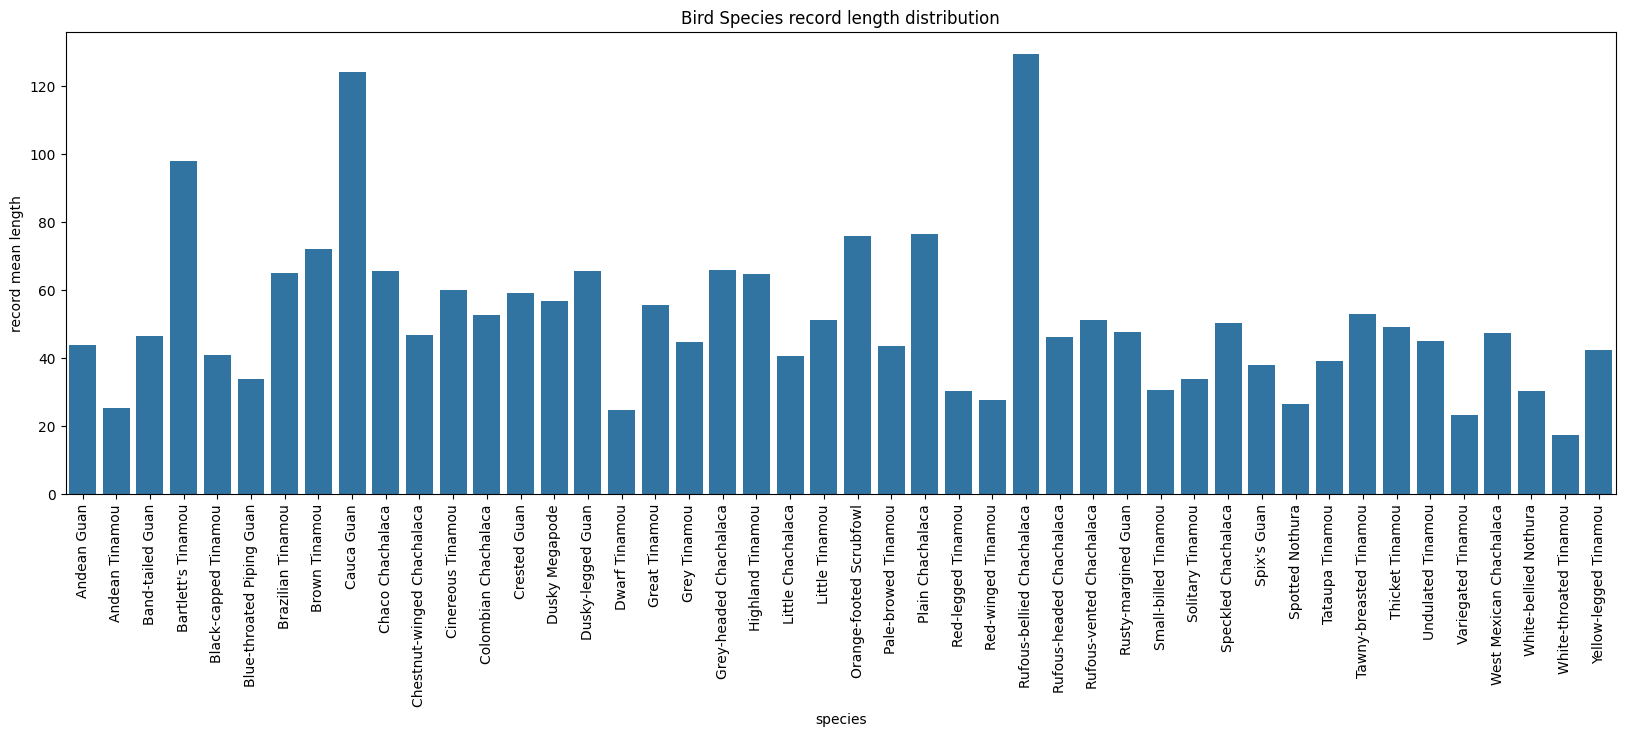

In [15]:
s_classes = list(np.unique(org_data.common_name))
s_class_distribution = org_data.groupby(['common_name'])['recording_length_seconds'].mean()
s_class_distribution_df = pd.DataFrame(columns=['common_name','record mean length'])
s_class_distribution_df['common_name'] = s_class_distribution.index
s_class_distribution_df['record mean length'] = s_class_distribution.values

plt.figure(figsize=(20, 6))

sns.barplot(x='common_name', y='record mean length', data=s_class_distribution_df)

plt.xticks(rotation=90)

plt.title('Bird Species record length distribution')
plt.xlabel('species')
plt.ylabel('record mean length')
plt.show()

#### Observation: According to the length distribution of each species above, even though each species has 30 or more data, the distribution of length doesn't seem equal. So for the metrics of model, probably we will decide to use the metrics like precision, recall, F1-score, instead of accuracy

# Pick the training feature and target

In [16]:
features = org_data['audio_array']
labels = org_data['b_class']

In [17]:
# Conduct One-Hot Encoding to target column
labels_ohe = pd.get_dummies(labels, columns=['b_class'], dtype=float)
labels_ohe

0    1    2    3    4    5    6    7    8    9   ...   36   37   38  \
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1375  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1376  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1377  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1378  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1379  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       39   40   41   42   43   44   45  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
1375  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1376  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1377  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1378  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
1379  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[1379 rows x 46 columns]

In [18]:
labels_ohe.shape

(1379, 46)

In [19]:
feat_list = np.empty((len(features), 128, 128, 1))  # Assuming 128x128x1 shape for each feature
for i, feature in enumerate(features):
    feat_list[i] = feature

feat_list.shape

(1379, 128, 128, 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(feat_list, labels_ohe, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(827, 128, 128, 1)
(827, 46)
(276, 128, 128, 1)
(276, 46)
(276, 128, 128, 1)
(276, 46)


In [22]:
model = build_cnn_model()
model.summary()


c:\Users\aqua6\anaconda3\envs\Bird\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 46)   │           460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 46)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        26,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,323,514 (12.68 MB)

 Trainable params: 3,323,514 (12.68 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32,validation_data=(X_val, y_val))

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 3.8426 - recall: 0.0000e+00 - val_loss: 3.8301 - val_recall: 0.0000e+00
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - loss: 3.8227 - recall: 0.0000e+00 - val_loss: 3.8233 - val_recall: 0.0000e+00
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - loss: 3.7905 - recall: 0.0000e+00 - val_loss: 3.8147 - val_recall: 0.0036
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - loss: 3.6917 - recall: 0.0068 - val_loss: 3.6951 - val_recall: 0.0036
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - loss: 3.5064 - recall: 0.0252 - val_loss: 3.5328 - val_recall: 0.0217
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - loss: 3.1999 - recall: 0.0575 - val_loss: 3.2041 - val_recall: 0.0906
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - loss: 2.8818 - recall: 0.1104 - val_loss: 2.8966 - val_recall: 0.1123
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - loss: 2.5432 - recall: 0.1587 - val_loss: 2.5534 - val_rec

In [24]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.3491 - recall: 0.5964
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.6890 - recall: 0.6269
Validation: accuracy = 0.590580  ;  loss_v = 2.584432
Test: accuracy = 0.586957  ;  loss = 2.550368


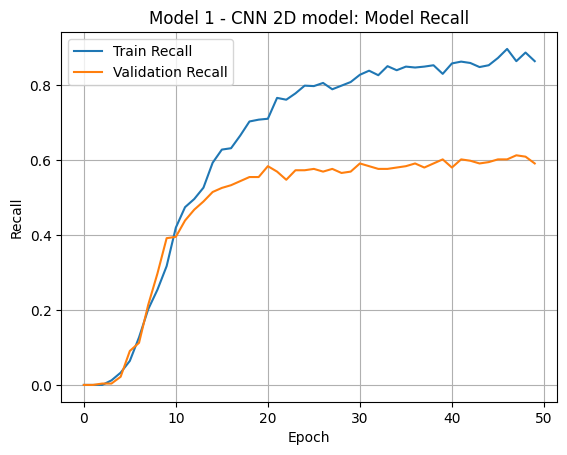

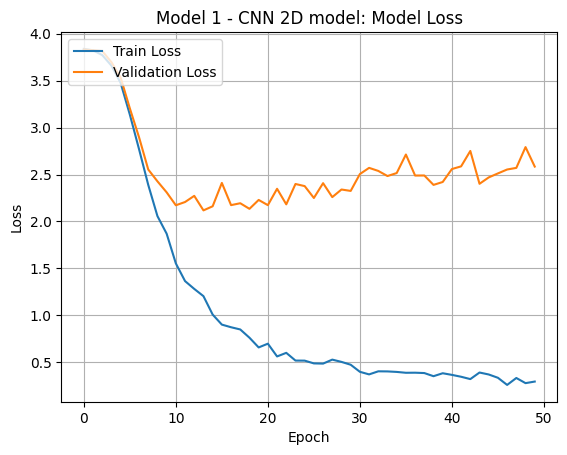

In [26]:
# Accuracy and Loss Visualization
def plot_history(history, experiment_name):
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title(f'{experiment_name}: Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{experiment_name}: Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()


plot_history(history, "Model 1 - CNN 2D model")

In [27]:
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [28]:
# Convert probabilities to one-hot encoded labels (example using thresholding)
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0)  # 1 for probabilities above threshold, 0 otherwise

# Now use classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.33      0.50         9
           2       0.33      0.12      0.18         8
           3       0.22      0.40      0.29         5
           4       0.25      0.50      0.33         2
           5       0.50      0.40      0.44         5
           6       0.71      1.00      0.83         5
           7       1.00      0.25      0.40         8
           8       0.75      0.43      0.55         7
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       0.86      0.86      0.86         7
          12       0.29      0.50      0.36         4
          13       0.67      0.50      0.57         4
          14       1.00      0.62      0.77         8
          15       1.00      0.50      0.67         6
          16       1.00      1.00      1.00         5
          17       0.67    

c:\Users\aqua6\anaconda3\envs\Bird\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aqua6\anaconda3\envs\Bird\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model 2

In [29]:
model_2 = cnn_2D_model_2()
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


c:\Users\aqua6\anaconda3\envs\Bird\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - loss: 3.8586 - recall: 0.0000e+00 - val_loss: 3.7818 - val_recall: 0.0000e+00
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - loss: 3.5583 - recall: 0.0096 - val_loss: 3.1910 - val_recall: 0.0399
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 2.4496 - recall: 0.1696 - val_loss: 2.3424 - val_recall: 0.3080
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - loss: 1.2438 - recall: 0.5071 - val_loss: 2.3945 - val_recall: 0.4855
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 0.6609 - recall: 0.7451 - val_loss: 2.2643 - val_recall: 0.5870
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - loss: 0.3487 - recall: 0.8652 - val_loss: 2.4350 - val_recall: 0.6196
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 0.2656 - recall: 0.9097 - val_loss: 2.3701 - val_recall: 0.6123
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - loss: 0.1044 - recall: 0.9743 - val_loss: 2.9034 - val_recall: 0.6123


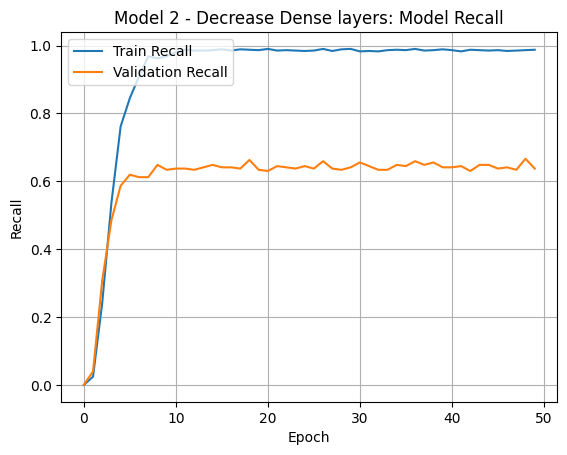

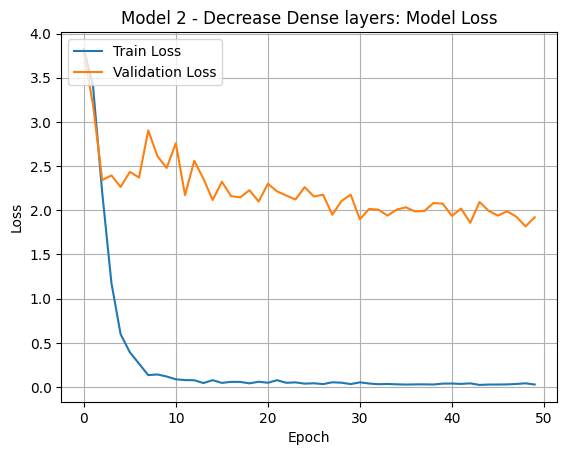

In [30]:
# Example of usage for one experiment:
plot_history(history_2, "Model 2 - Decrease Dense layers")

In [31]:
y_pred_2 = model_2.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [32]:
# Convert probabilities to one-hot encoded labels (example using thresholding)
threshold = 0.5
y_pred_2 = np.where(y_pred_2 > threshold, 1, 0)  # 1 for probabilities above threshold, 0 otherwise

# Now use classification_report
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.80      0.44      0.57         9
           2       0.25      0.12      0.17         8
           3       0.40      0.40      0.40         5
           4       1.00      0.50      0.67         2
           5       0.67      0.40      0.50         5
           6       0.67      0.80      0.73         5
           7       1.00      0.25      0.40         8
           8       1.00      0.43      0.60         7
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       0.86      0.86      0.86         7
          12       1.00      0.50      0.67         4
          13       0.75      0.75      0.75         4
          14       1.00      0.62      0.77         8
          15       1.00      0.50      0.67         6
          16       0.71      1.00      0.83         5
          17       0.00    

c:\Users\aqua6\anaconda3\envs\Bird\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
